In [1]:
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Reshape, GRU

os.environ['CUDA_VISIBLE_DEVICES']="2"

In [2]:
train_x_df=pd.read_csv('train_x_df.csv')
train_y_df=pd.read_csv('train_y_df.csv')
test_x_df=pd.read_csv('test_x_df.csv')
sample_submission=pd.read_csv('sample_submission.csv')

In [3]:
print(len(train_x_df)/1380, len(train_y_df)/120)

7929.0 7929.0


In [4]:
print(train_x_df.sample_id.nunique())
print(train_y_df.sample_id.nunique())

7929
7929


In [5]:
train_x_df.head(2)

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,0,0.993147,0.993546,0.992857,0.992966,1379.478027,3778.584961,11.240029,329.655548,903.091614
1,0,1,0,0.993256,0.993546,0.992712,0.992712,3438.807373,9419.426758,11.602611,1363.999268,3737.512695


In [6]:
train_y_df.head(2)

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,0,1.000326,1.002683,0.999420,1.00116,6848.100586,18914.638672,56.925312,2409.717285,6656.051270
1,0,1,0,1.001342,1.001450,0.999347,1.00000,5056.033691,13946.318359,42.059464,2371.283691,6540.831543


In [7]:
len(test_x_df)/1380

760.0

iloc를 사용해 필요없는 index없앰

In [8]:
train_x_df.iloc[:,3:].values

array([[9.93147254e-01, 9.93546128e-01, 9.92857218e-01, ...,
        1.12400293e+01, 3.29655548e+02, 9.03091614e+02],
       [9.93255973e-01, 9.93546128e-01, 9.92712140e-01, ...,
        1.16026106e+01, 1.36399927e+03, 3.73751270e+03],
       [9.92748380e-01, 9.94815111e-01, 9.92458344e-01, ...,
        1.95794067e+01, 1.22280286e+03, 3.35068872e+03],
       ...,
       [9.99707699e-01, 1.00000000e+00, 9.99488533e-01, ...,
        6.20981872e-01, 7.88707495e-01, 1.07937714e+02],
       [9.99707699e-01, 1.00014603e+00, 9.99488533e-01, ...,
        7.52483904e-01, 8.69763434e-01, 1.19042564e+02],
       [1.00000000e+00, 1.00029218e+00, 9.99853849e-01, ...,
        3.94506127e-01, 5.62873721e-01, 7.70531311e+01]])

1380분 후 120분을 예측하는 모델을 만들기 위한 reshape

In [9]:
train_x = tf.reshape(train_x_df.iloc[:,3].values, [-1, 1380, 1])
train_y = tf.reshape(train_y_df.iloc[:,3].values, [-1, 120, 1])
test_x = tf.reshape(test_x_df.iloc[:,3].values, [-1, 1380, 1])

In [10]:
train_x[:, 1379, 0]

<tf.Tensor: shape=(7929,), dtype=float64, numpy=array([1., 1., 1., ..., 1., 1., 1.])>

In [11]:
test_x[:, 1379, 0]

<tf.Tensor: shape=(760,), dtype=float64, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

shape 확인, 학습을 위한 7929개의 샘플, test를 위한 760개의 샘플

In [12]:
print(train_x.shape, train_y.shape, test_x.shape)

(7929, 1380, 1) (7929, 120, 1) (760, 1380, 1)


np.arrange로 1380~1500반환

train_x.shape[1]이 1380, train_y.shape[1]이 120,

train_x[row,:,0]은 1380, train_y[row, :, 0]은 120

In [68]:
train_x[row,:,0]

<tf.Tensor: shape=(1380,), dtype=float64, numpy=
array([1.04582441, 1.04666603, 1.04685307, ..., 0.99869072, 1.00037408,
       1.        ])>

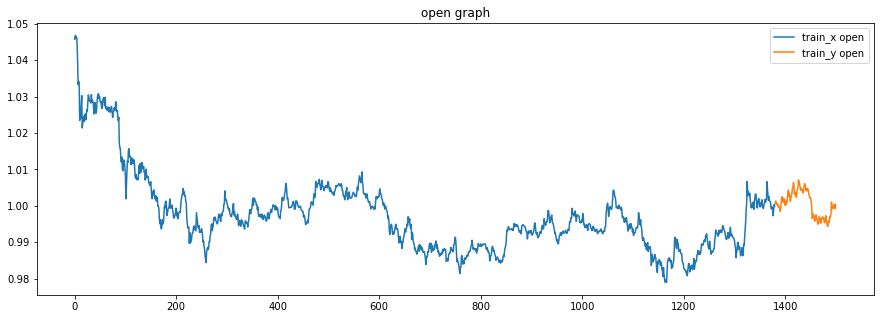

In [69]:
row=1
plt.figure(figsize=(15,5))


plt.plot(train_x[row,:,0], label='train_x open')
plt.plot(np.arange(train_x.shape[1],train_x.shape[1]+ train_y.shape[1]), train_y[row, :, 0], label='train_y open')
plt.legend()
plt.title('open graph')
plt.show()

In [15]:
train_x.shape

TensorShape([7929, 1380, 1])

In [51]:
train_y.shape

TensorShape([7929, 120, 1])

In [17]:
input_window=170
output_window=60
num_features=1
window=input_window + output_window

train_window_x= np.zeros(( train_x.shape[0], (train_x.shape[1]-(input_window + output_window))//230, input_window, num_features))
train_window_y= np.zeros(( train_x.shape[0], (train_x.shape[1]-(input_window + output_window))//230, output_window, num_features))
print(train_window_x.shape, train_window_y.shape)

for example in range(train_x.shape[0]):
    
    for start in range(0,  train_x.shape[1]-(input_window + output_window), 230):
        end=start+input_window
        train_window_x[example, start//230, :, :] = train_x[example, start: end               , :]
        train_window_y[example, start//230, :, :] = train_x[example, end  : end+ output_window, :]

(7929, 5, 170, 1) (7929, 5, 60, 1)


In [18]:

new_train_x=tf.reshape(train_window_x, [-1, 170, 1])
new_train_y=tf.reshape(train_window_y, [-1, 60, 1])

In [36]:
time        = new_train_x.shape[1] #170
num_features= new_train_x.shape[2] #1
OUT_STEPS   = new_train_y.shape[1] #60

#####층 쌓기###########


model=Sequential([
LSTM(32, input_shape=(time, num_features), dropout=0.2, recurrent_dropout=0.2),
Dense(OUT_STEPS * num_features), 
Reshape([OUT_STEPS, num_features])
])



#######Compile 구성하기################


model.compile(optimizer='rmsprop', loss='mae', metrics=['mae', 'accuracy'])
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

#가장 좋은 성능을 낸 val_loss가 적은 model만 남겨 놓았습니다.
save_best_only=tf.keras.callbacks.ModelCheckpoint(filepath="lstm_model.h5", monitor='val_loss', save_best_only=True)


early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

#검증 손실이 10epoch 동안 좋아지지 않으면 학습률을 0.1 배로 재구성하는 명령어입니다.
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)


######################
history = model.fit(new_train_x, new_train_y, epochs=1, batch_size=128, validation_split = 0.2, verbose=0, callbacks=[PrintDot(), early_stop, save_best_only , reduceLR])


.

In [37]:
pd.DataFrame(history.history)

,loss,mae,accuracy,val_loss,val_mae,val_accuracy,lr
0,0.09792,0.09792,0.002224,0.028797,0.028797,0.002028,0.001


In [21]:
print(new_train_x.shape, new_train_y.shape)

(39645, 170, 1) (39645, 60, 1)


In [22]:
test_x = tf.reshape(test_x_df.iloc[:,3].values, [-1, 1380, 1])

In [23]:
auto_x=test_x
auto_x.shape

TensorShape([760, 1380, 1])

In [26]:
submission=np.zeros((760, 120, 9))

In [27]:
end_=120
output_window = 60

for i in range(end_//output_window):
    start_ = i *output_window
    next_ = model.predict(auto_x[:, -170:, :])
    auto_x=tf.concat([auto_x, next_], axis=1)
    print(auto_x.shape)
    submission[:, start_ : start_ + output_window, :] = next_

(760, 1500, 1)
(760, 1560, 1)


In [28]:
submission.shape

(760, 120, 9)

In [59]:
submission

array([[[1.02421665, 1.02421665, 1.02421665, ..., 1.02421665,
         1.02421665, 1.02421665],
        [1.02473438, 1.02473438, 1.02473438, ..., 1.02473438,
         1.02473438, 1.02473438],
        [1.01606822, 1.01606822, 1.01606822, ..., 1.01606822,
         1.01606822, 1.01606822],
        ...,
        [1.01149237, 1.01149237, 1.01149237, ..., 1.01149237,
         1.01149237, 1.01149237],
        [1.01185524, 1.01185524, 1.01185524, ..., 1.01185524,
         1.01185524, 1.01185524],
        [1.01459992, 1.01459992, 1.01459992, ..., 1.01459992,
         1.01459992, 1.01459992]],

       [[1.0242151 , 1.0242151 , 1.0242151 , ..., 1.0242151 ,
         1.0242151 , 1.0242151 ],
        [1.02473378, 1.02473378, 1.02473378, ..., 1.02473378,
         1.02473378, 1.02473378],
        [1.01606715, 1.01606715, 1.01606715, ..., 1.01606715,
         1.01606715, 1.01606715],
        ...,
        [1.01149237, 1.01149237, 1.01149237, ..., 1.01149237,
         1.01149237, 1.01149237],
        [1.0

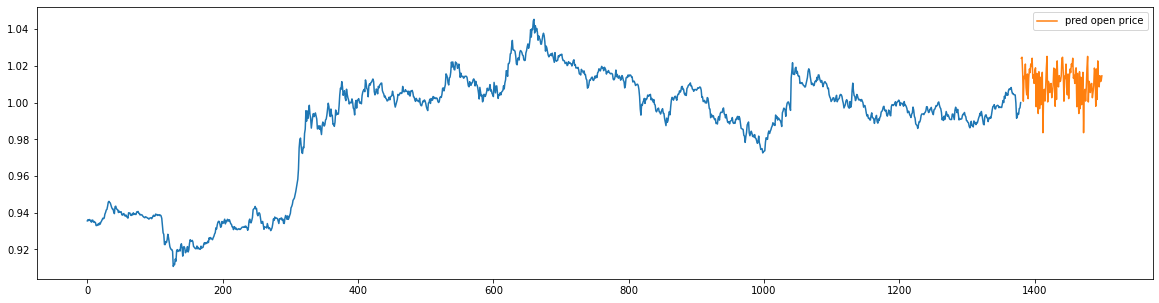

In [29]:
row +=1
plt.figure(figsize=(20,5))

plt.plot(test_x[row,:, 0])
plt.plot(np.arange(test_x.shape[1], test_x.shape[1]+ submission.shape[1]), submission[row, :, 0], label='pred open price')
plt.legend()
plt.show()

In [55]:
test_x[row,:, 0]

<tf.Tensor: shape=(1380,), dtype=float64, numpy=
array([0.97690755, 0.97693282, 0.97736377, ..., 0.99254751, 0.99328268,
       1.        ])>

In [74]:
submit_columns = [
                  "sample_id", 
                  "buy_quantity", 
                  "sell_time"
                  ]

In [78]:
submit1 = submission[:,:,0]

In [79]:
submit = pd.DataFrame(data=submit1, columns=submit_columns)

ValueError: Shape of passed values is (760, 120), indices imply (760, 3)

In [73]:
submission

array([[[1.02421665, 1.02421665, 1.02421665, ..., 1.02421665,
         1.02421665, 1.02421665],
        [1.02473438, 1.02473438, 1.02473438, ..., 1.02473438,
         1.02473438, 1.02473438],
        [1.01606822, 1.01606822, 1.01606822, ..., 1.01606822,
         1.01606822, 1.01606822],
        ...,
        [1.01149237, 1.01149237, 1.01149237, ..., 1.01149237,
         1.01149237, 1.01149237],
        [1.01185524, 1.01185524, 1.01185524, ..., 1.01185524,
         1.01185524, 1.01185524],
        [1.01459992, 1.01459992, 1.01459992, ..., 1.01459992,
         1.01459992, 1.01459992]],

       [[1.0242151 , 1.0242151 , 1.0242151 , ..., 1.0242151 ,
         1.0242151 , 1.0242151 ],
        [1.02473378, 1.02473378, 1.02473378, ..., 1.02473378,
         1.02473378, 1.02473378],
        [1.01606715, 1.01606715, 1.01606715, ..., 1.01606715,
         1.01606715, 1.01606715],
        ...,
        [1.01149237, 1.01149237, 1.01149237, ..., 1.01149237,
         1.01149237, 1.01149237],
        [1.0

In [49]:
subm = pd.DataFrame(submission[row, :, 0])

In [50]:
subm.to_csv("hioo.csv")

In [30]:
row=1
submission[row,:,:]

array([[1.0242151 , 1.0242151 , 1.0242151 , ..., 1.0242151 , 1.0242151 ,
        1.0242151 ],
       [1.02473378, 1.02473378, 1.02473378, ..., 1.02473378, 1.02473378,
        1.02473378],
       [1.01606715, 1.01606715, 1.01606715, ..., 1.01606715, 1.01606715,
        1.01606715],
       ...,
       [1.01149237, 1.01149237, 1.01149237, ..., 1.01149237, 1.01149237,
        1.01149237],
       [1.01185524, 1.01185524, 1.01185524, ..., 1.01185524, 1.01185524,
        1.01185524],
       [1.01459992, 1.01459992, 1.01459992, ..., 1.01459992, 1.01459992,
        1.01459992]])

In [77]:
submission[row,:,:].shape

(120, 9)

In [57]:
best_model = ModelCheckpoint()
pred = best_model.submission(test_X)
pred[:5]

NameError: name 'ModelCheckpoint' is not defined

In [ ]:
rlyStopp